# <span style="color:lightblue; font-weight:bold;">DETECTOR D'OPINIONS</span>

## <span style="color:#ADD8E6; font-weight:bold;">Índex:</span>
### <span style="color:#FFFFFF;">1. [Supervisat (Pràctica 2.a)](#supervisat)</span>
#### <span style="color:#FFFFFF;">1. 1 [Preprocessament](#preprocessing1)</span>
### <span style="color:#ADD8E6;">2. [No supervisat (Pràctica 2.b)](#no-supervisat)</span>
#### <span style="color:#FFFFFF;">2. 1 [Preprocessament](#preprocessing2)</span>
### <span style="color:#ADD8E6;">3. [Conclusions](#conclusions)</span>

## <span style="color:lightblue;"> Imports </span>

In [1]:
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import movie_reviews
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from string import punctuation
from nltk.wsd import lesk
from nltk.corpus import sentiwordnet as swn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

## <span style="color:lightblue;"> Descargues </span>

In [ ]:
%pip install scikit-learn nltk
%pip install seaborn

In [2]:
# Descargar recursos adicionales de NLTK
nltk.download('punkt')
nltk.download('movie_reviews')
nltk.download('stopwords')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## <span style="color:lightblue; font-weight:bold;">Supervisat (Pràctica 2.a)</span> <a id="supervisat"></a>

### <span style="color:lightblue;"> Preprocessament </span> <a id="preprocessing1"></a>

<span style="color:white;" > Per a poder entrenar el model correctament hem realitzat el següent preprocessament, primer hem tret les 'stop words' excepte les paraules 'not, no, never', ja que creiem que aquestes poden tenir importància per a detectar si l'opinió és positiva o negativa. Seguidament hem eliminat els signes de puntuació. I finalment, hem separat les opinions i les seves categories que indiquen si són positives o negatives. </span>

In [3]:
# Obtenim la llista de paraules buides i definim signes de puntuació
stop_words = set(nltk.corpus.stopwords.words('english'))
punctuations = set(punctuation)

# Agreguem les paraules que desitgem mantenir de la llista de paraules buides
words_to_keep = ["not", "no", "never"]
stop_words = stop_words.difference(set(words_to_keep))


def preprocess_text(text):
    
    """ 
    Tokenitzem el text, i ens quedem amb les paraules 
    que no són signes de puntuació ni paraules buides
    """
    
    tokens = nltk.word_tokenize(text.lower())
    
    tokens = [word for word in tokens if word.isalpha() and word not in punctuations and word not in stop_words]
    #tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

# Obtenim les opinions i les seves categories
documents = [(preprocess_text(movie_reviews.raw(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

reviews = [opinion[0] for opinion in documents]
labels = [opinion[1] for opinion in documents]


<span style="color:white;" > Per trobar el millor valor per al paràmetre 'min_df' per al nostre model, hem creat una llista amb diversos valors amb els quals entrenarem diversos models per a avaluar els resultats. Després d'aquesta exploració, hem determinat que el valor òptim per al paràmetre 'min_df' és 35. Aquest serà el valor que utilitzarem per a la construcció dels nostres models. </span>

In [29]:
# Llista de possibles valors per a min_df
min_df_values = [1, 5, 10, 11, 12, 13, 14, 15, 20]

# Llista per emmagatzemar els resultats de la validació creuada
cv_scores = []

# Iterem sobre els valors de min_df
for min_df in min_df_values:
    # Inicialitzem i ajustem el CountVectorizer amb el valor actual de min_df
    vectorizer = CountVectorizer(min_df=min_df)
    X = vectorizer.fit_transform(reviews)
    
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
    
    # Inicialitzem i ajustem el model MultinomialNB
    model = MultinomialNB()
    model.fit(X_train, y_train)
    
    # Avaluem el model utilitzant validació creuada
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Trobem el millor valor de min_df
best_min_df_index = np.argmax(cv_scores)
best_min_df = min_df_values[best_min_df_index]
best_cv_score = cv_scores[best_min_df_index]

print("El millor valor de min_df és:", best_min_df)
print("La puntuació de validació creuada corresponent és:", best_cv_score)

El millor valor de min_df és: 14
La puntuació de validació creuada corresponent és: 0.8150000000000001


<span style="color:white;" > A continuació, inicialitzem el 'vectoritzador' amb un valor de 'min_df' igual a 14, ja que com hem vist anteriorment és l'òptim. Aquest paràmetre és crucial per representar les nostres dades amb eficàcia. Posteriorment, procedim a dividir el conjunt de dades en conjunts d'entrenament i de prova. El 'min_df' ens ajuda a donar prioritat a les paraules que apareixen amb una freqüència significativa en diferents documents. En altres paraules, considera la presència d'una paraula en múltiples documents, en lloc de simplement comptar quantes vegades apareix en un sol document. Això ens permet obtenir una representació més robusta dels nostres textos.</span>

In [30]:
vectorizer = CountVectorizer(min_df=14)

X = vectorizer.fit_transform(reviews)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

<span style="color:white;" >
    Per fer la predicció seguint l'aprenentatge supervisat, hem seleccionat quatre models supervisats diferents per a comparar-los i determinar quin generalitza millor per obtenir resultats bons. <br>
    Els models supervisats escollits són els següents: 
    <ol style="color:white;">
        <li>Multinomial Naive Bayes (MultinomialNB)</li>
        <li>Màquines de Vector Suport (SVM)</li>
        <li>Regressió Logística (Logistic Regression)</li>
        <li>Arbres de Decisió (Decision Tree)</li>
    </ol>
</span>


<span style="color:white;" > Primerament, fem 'grid_search' per a trobar els millors paràmetres per cada model. </span>

In [31]:
nb_param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0],
    'fit_prior': [True, False],
    'class_prior': [None, [0.3, 0.7], [0.5, 0.5]]
}
nb_grid_search = GridSearchCV(MultinomialNB(), nb_param_grid, cv=5)
nb_grid_search.fit(X_train, y_train)
print("Millors paràmetres per a Naive Bayes:",nb_grid_search.best_params_)

Millors paràmetres per a Naive Bayes: {'alpha': 10.0, 'class_prior': [0.3, 0.7], 'fit_prior': True}


In [40]:
svm_param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']}
svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5)
svm_grid_search.fit(X_train, y_train)
print("Millors paràmetres per a SVM:", svm_grid_search.best_params_)

Millors paràmetres per a SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [33]:
logistic_param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}  
logistic_grid_search = GridSearchCV(LogisticRegression(max_iter=1000), logistic_param_grid, cv=5)
logistic_grid_search.fit(X_train, y_train)
print("Millors paràmetres per a Regresión Logística:", logistic_grid_search.best_params_)

Millors paràmetres per a Regresión Logística: {'C': 0.1, 'solver': 'newton-cg'}


In [34]:
tree_param_grid = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
tree_grid_search = GridSearchCV(DecisionTreeClassifier(), tree_param_grid, cv=5)
tree_grid_search.fit(X_train, y_train)
print("Millors paràmetres per a Decision Tree:", tree_grid_search.best_params_)

Millors paràmetres per a Decision Tree: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}


<span style="color:white;" > Provem ara quines són les prediccions fetes. </span>

In [35]:
nb_model = MultinomialNB(alpha=nb_grid_search.best_params_['alpha'], 
                        fit_prior=nb_grid_search.best_params_['fit_prior'], 
                        class_prior=nb_grid_search.best_params_['class_prior'])
nb_model.fit(X_train, y_train)

svm_model = SVC(C=svm_grid_search.best_params_['C'], 
                gamma=svm_grid_search.best_params_['gamma'], 
                kernel=svm_grid_search.best_params_['kernel'])
svm_model.fit(X_train, y_train)

logistic_model = LogisticRegression(max_iter=1000,  
                                    C=logistic_grid_search.best_params_['C'], 
                                    solver=logistic_grid_search.best_params_['solver'])
logistic_model.fit(X_train, y_train)

decision_tree_model = DecisionTreeClassifier(max_depth=tree_grid_search.best_params_['max_depth'], 
                                             min_samples_leaf=tree_grid_search.best_params_['min_samples_leaf'], 
                                             min_samples_split=tree_grid_search.best_params_['min_samples_split'])
decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=10)

<span style="color:white;" > Per a poder veure quins models generalitzen millor usarem el mètode de 'cross validation' en aquest cas per a cada model fem 5 particions. A continuació podem observar els resultats. Com podem veure en els resultats els models que tenen millor 'accuracy' són 'SVM' i 'Logistic Regression'. </span>

In [36]:
# Validació creuada per a Naive Bayes
nb_cv_scores = cross_val_score(nb_model, X_train, y_train, cv=5)
print("Naive Bayes Cross-Validation Scores:", nb_cv_scores)
print(f"Mean Naive Bayes Cross-Validation Score: {nb_cv_scores.mean():.3f}")
print("\n")

# Validació creuada per a SVM
svm_cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5)
print("SVM Cross-Validation Scores:", svm_cv_scores)
print(f"Mean SVM Cross-Validation Score: {svm_cv_scores.mean():.3f}")
print("\n")

# Validació creuada per a Regresión Logística
logistic_cv_scores = cross_val_score(logistic_model, X_train, y_train, cv=5)
print("Logistic Regression Cross-Validation Scores:", logistic_cv_scores)
print(f"Mean Logistic Regression Cross-Validation Score: {logistic_cv_scores.mean():.3f}")
print("\n")

# Validació creuada per a Decision Tree
decision_tree_cv_scores = cross_val_score(decision_tree_model, X_train, y_train, cv=5)
print("Decision Tree Cross-Validation Scores:", decision_tree_cv_scores)
print(f"Mean Decision Tree Cross-Validation Score: {decision_tree_cv_scores.mean():.3f}")


Naive Bayes Cross-Validation Scores: [0.83125  0.834375 0.803125 0.846875 0.803125]
Mean Naive Bayes Cross-Validation Score: 0.824


SVM Cross-Validation Scores: [0.81875  0.875    0.8125   0.853125 0.809375]
Mean SVM Cross-Validation Score: 0.834


Logistic Regression Cross-Validation Scores: [0.825    0.871875 0.8125   0.84375  0.815625]
Mean Logistic Regression Cross-Validation Score: 0.834


Decision Tree Cross-Validation Scores: [0.615625 0.665625 0.628125 0.628125 0.615625]
Mean Decision Tree Cross-Validation Score: 0.631


<span style="color:white;" > Seguidament, mirem els resultats per a la partició del test i observem que els models de 'SVM' i 'Logistic regression' també són els que obtenen millor 'accuracy' en la partició del 'test'. </span>

In [37]:
# Realitza les prediccions per als conjunts de prova
y_pred_mnb = nb_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)
y_pred_logistic = logistic_model.predict(X_test)
y_pred_decision_tree = decision_tree_model.predict(X_test)

# Calcular accuracies
accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)

# Crear el dataframe
data = {
    'Model': ['Multinomial Naive Bayes', 'SVM', 'Regresió Logistica', 'Arbre de Decisió'],
    'Accuracy': [accuracy_mnb, accuracy_svm, accuracy_logistic, accuracy_decision_tree]
}

taula_accuracy = pd.DataFrame(data)

# Mostrar la taula
print(taula_accuracy)

                     Model  Accuracy
0  Multinomial Naive Bayes    0.8250
1                      SVM    0.8275
2       Regresió Logistica    0.8300
3         Arbre de Decisió    0.6225


<span style="color:white;" > A continuació podem observar la matriu de confusió del model realitzat amb 'SVM' i 'logistic regression', ja que són els models que generalitzen millor. Podem veure com la majoria dels valors es troben en la diagonal i que les vegades que ha predit malament les positives i les negatives són molt semblants. </span>

Accuracy SVM: 0.8275


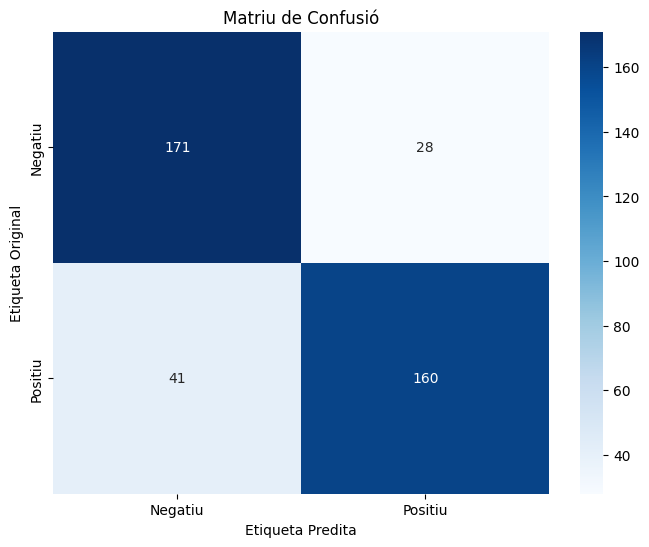

In [38]:
print('Accuracy SVM:',accuracy_score(y_test, y_pred_svm))

# Calcula la matriu de confusió
conf_matrix = confusion_matrix(y_test, y_pred_svm)

# Defineix les etiquetas de les clases
classes = ['Negatiu', 'Positiu']

# Crea la figura
plt.figure(figsize=(8, 6))

# Crea la matriu de confusió com un mapa de calor
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Etiquetas y títol
plt.xlabel('Etiqueta Predita')
plt.ylabel('Etiqueta Original')
plt.title('Matriu de Confusió')

# Mostra la matriu de confusió
plt.show()

Accuracy Logistic Regression:  0.83


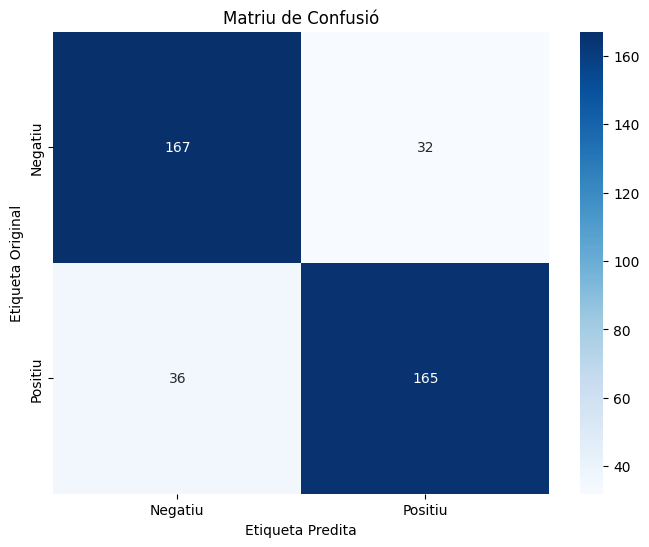

In [39]:
print('Accuracy Logistic Regression: ',accuracy_score(y_test, y_pred_logistic))

# Calcula la matriu de confusió
conf_matrix = confusion_matrix(y_test, y_pred_logistic)

# Defineix les etiquetas de les clases
classes = ['Negatiu', 'Positiu']

# Crea la figura
plt.figure(figsize=(8, 6))

# Crea la matriu de confusió com un mapa de calor
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Etiquetas y títol
plt.xlabel('Etiqueta Predita')
plt.ylabel('Etiqueta Original')
plt.title('Matriu de Confusió')

# Mostra la matriu de confusió
plt.show()


<span style="color:white;" > Si comparem les matrius de confusió, observem que la 'regressió logística' fa prediccions molt equilibrades, és a dir, prediu amb la mateixa probabilitat les categories negatives i positives. En canvi, el model 'SVM' fa prediccions una mica desbalancejades, decantant-se per fer prediccions més negatives. </span>

## <span style="color:lightblue; font-weight:bold;">No supervisat (Pràctica 2.b)</span> <a id="no-supervisat"></a>

<span style="color:white;" > A continuació fem la partició 'train', 'test' amb la mateixa llavor que en els models supervisats per obtenir la mateixa partició, però ara amb les 'reviews' sense vectoritzar. </span>

In [17]:
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=42)

### <span style="color:lightblue;" >Preprocessament </span> <a id="preprocessing2"></a>

<span style="color:white;" > En aquest preprocessament després d'haver provat diferents combinacions (queda per fer la comprovació) ens quedem amb els noms els adjectius i els adverbis. </span>

In [18]:
pos_combinations = [('N', 'JJ'), ('N', 'RB'), ('N', 'JJ', 'RB'), ('N', 'VB'), ('JJ'), ('JJ', 'RB'), ('N', 'JJ', 'RB', 'VB')]

def keep_specific_pos(review, pos_combo):
    
    # Tokenizar el text en oracions i paraules
    sentences = sent_tokenize(review)
    tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

    # Mantenir les paraules específiques per categoria gramatical
    filtered_sentences = []
    for sentence in tokenized_sentences:
        tagged_words = nltk.pos_tag(sentence)            
        filtered_sentence = [word for word, pos in tagged_words if pos.startswith(pos_combo)]
            
        filtered_sentences.append(filtered_sentence)

    # Reconstruir les oracions filtrades
    filtered_review = [' '.join(sentence) for sentence in filtered_sentences]
    return ' '.join(filtered_review)

pos_combinacions_reviews = []
for pos_combo in pos_combinations:
# Conservar els substantius, adjectius, verbs i adverbis de cada revisió
    filtered_reviews = [keep_specific_pos(review, pos_combo) for review in X_test]
    pos_combinacions_reviews.append(filtered_reviews)

### <span style="color:lightblue;">Lesk</span>

<span style="color:white;" > Per determinar si una opinió és positiva o negativa, utilitzem el context de les paraules, que ens proporcionen una puntuació segons el 'SentiWordNet'. Si una paraula no està present en el 'SentiWordNet', assignem una puntuació de 0, ja que no podem determinar si és positiva o negativa i, per tant, la considerem neutra en el context. Després d'obtenir les puntuacions de les paraules, les sumem. Si la suma és superior a 0, l'opinió es considera positiva; si és inferior a 0, es considera negativa. </span>

In [19]:
# Funció per obtenir la puntuació de polaritat d'una paraula utilitzant de Lesk
def get_word_sentiment_score_with_lesk(word, context):
    # Obtenir el synset amb Lesk
    synset = lesk(context, word)
    if synset:
        # Obtenir els sentiments associats al synset de SentiWordnet
        sent_synset = swn.senti_synset(synset.name())
        if sent_synset: 
            return sent_synset.pos_score() - sent_synset.neg_score()
    return 0

best_accuracy = 0
best_lesk_sentences = None

# Umbral de polaritat
threshold = 0

for index, filtered_review in enumerate(pos_combinacions_reviews):
    
    predicted_labels = []
    
    # Procesar cada opinió
    for opinion in filtered_review:
        
        # Tokenizar la opinió
        tokens = word_tokenize(opinion)
        total_sentiment_score = 0
        word_count = 0
        for i, token in enumerate(tokens):
            
            # Obtenir el contexto de la paraula (paraules circumdants)
            context = tokens[max(0, i-5):i] + tokens[i+1:min(len(tokens), i+6)]
            
            # Calcular la puntuació de polaritat de la paraula
            sentiment_score = get_word_sentiment_score_with_lesk(token, context)
            total_sentiment_score += sentiment_score
            word_count += 1
            
        # Calcular la puntuació de polaritat mitjana per a la opinió
        if word_count > 0:
            average_sentiment_score = total_sentiment_score / word_count
            # Determinar si la opinió és positiva, negativa o neutra
            if average_sentiment_score >= threshold:
                predicted_labels.append("pos")
            elif average_sentiment_score < threshold:
                predicted_labels.append("neg")

    # Calcular l'accuracy
    current_accuracy = accuracy_score(y_test, predicted_labels)
    
    # Actualizar la millor combinació si s'obté una millor accuracy
    if current_accuracy > best_accuracy:
        best_predicted_labels = predicted_labels
        best_lesk_sentences = pos_combinations[index]
        best_accuracy = current_accuracy
         
print("Best combination of POS tags:", best_lesk_sentences)
print("Best accuracy:", best_accuracy)

Best combination of POS tags: JJ
Best accuracy: 0.6525


<span style="color:white;" > A continuació, podem observar com la majoria dels valors es concentren a la diagonal principal, indicant prediccions correctes. No obstant això, es pot notar que fora de la diagonal hi ha valors notablement alts, especialment amb molts casos de negatives predites com a positives. Això suggereix la necessitat de millorar la capacitat del model per a identificar correctament les opinions negatives. </span>

0.6525


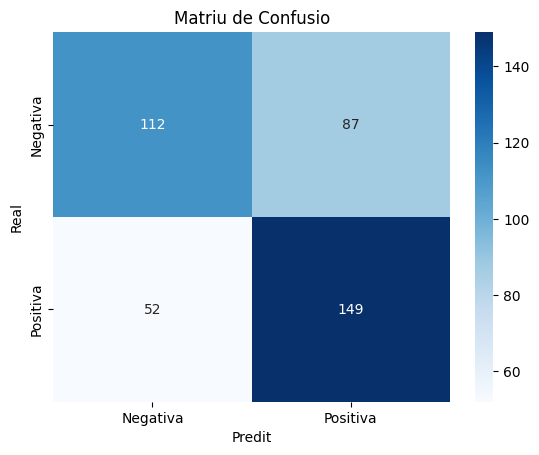

In [20]:
# Calcular la matriu de confusió
print(accuracy_score(y_test, best_predicted_labels))
conf_matrix = confusion_matrix(y_test, best_predicted_labels)

# Visualitzar la matriu de confusió
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negativa", "Positiva"], yticklabels=["Negativa", "Positiva"])
plt.xlabel("Predit")
plt.ylabel("Real")
plt.title("Matriu de Confusio")
plt.show()

### <span style="color:lightblue;">TextServer</span>

<span style="color:white;" > A continuació, vam intentar utilitzar 'Text Server', però ens va retornar errors a causa d'un gran nombre d'entrades. Com a alternativa, vam optar per usar el model amb l'algoritme 'LESK', que és el model que hem explicat anteriorment. </span>

In [71]:
import requests
import pandas as pd
import json
import sys
from functools import reduce

load = lambda r: json.loads(r.encode('utf-8'))
pars = lambda r: [p for p in r['paragraphs']]
sents = lambda p: [s for s in p['sentences']]
decode = lambda x: bytes(x,'latin1').decode('utf-8')
info = lambda s, f: [f(t) for t in s['tokens']]
tokensDecode = lambda s: [decode(t['form']) for t in s['tokens']]
tokens = lambda s: [t['form'] for t in s['tokens']]
flatten = lambda l: reduce(lambda x, y: x + y, l, [])

class TextServer:
  def __init__(self, user, pwd, service='morpho'):
    self.service = service
    self.request_data = {
      'username':user,
      'password':pwd,
      'language': 'ca',
      'output': 'json',
      'interactive':'1' 
    }

  def query(self, text):
    url = "http://frodo.lsi.upc.edu:8080/TextWS/textservlet/ws/processQuery/"+self.service
    self.request_data['text_input'] = text
    resp = requests.post(url, files=self.request_data)
    if resp.status_code != requests.codes.ok : 
      resp.raise_for_status()
    return resp.text

  def tokenizer(self, text):
    self.service = 'tokenizer'
    ctnt = self.query(text)
    return list(map(tokens, sents(pars(load(ctnt))[0])))

  def morpho(self, text, pandas=False):
    def cols(t):
      return [t['form'],t['lemma'],t['tag'],t['pos']]
      
    self.service = 'morpho'
    ctnt = self.query(text)
    if pandas:
      dt = list(map(lambda s: info(s, cols), sents(pars(load(ctnt))[0])))
      return pd.DataFrame(flatten(dt), columns=['forma', 'lema', 'tag', 'pos'])
    else:
      return list(map(lambda s: info(s, cols), sents(pars(load(ctnt))[0])))

  def senses(self, text, pandas=False):
    def cols(t):
      l = [t['form'],t['lemma'],t['tag'],t['pos']]
      l += [t['wn']] if 'wn' in t else ['N/A']
      return l
        
    self.service = 'senses'
    ctnt = self.query(text)
    if pandas:
      dt = list(map(lambda s: info(s, cols), sents(pars(load(ctnt))[0])))
      return pd.DataFrame(flatten(dt), columns=['forma', 'lema', 'tag', 'pos', 'synset'])
    else:
      return list(map(lambda s: info(s, cols), sents(pars(load(ctnt))[0])))

  def entities(self, text, pandas=False):
    def cols(t):
      l = [t['form'],t['lemma'],t['tag'],t['pos']]
      l += [t['wn']] if 'wn' in t else ['N/A']
      l += [t['neclass']] if 'neclass' in t else ['N/A']
      return l
        
    self.service = 'entities'
    ctnt = self.query(text)
    if pandas:
      dt = list(map(lambda s: info(s, cols), sents(pars(load(ctnt))[0])))
      return pd.DataFrame(flatten(dt), columns=['forma', 'lema', 'tag', 'pos', 'synset', 'neclass'])
    else:
      return list(map(lambda s: info(s, cols), sents(pars(load(ctnt))[0])))

  def dependencies(self, text, pandas=False):
    def filtre(d): 
      res = {}
      for k in d:
        if k != 'token':
          if k!='children':
            res[k] = d[k]
          else:
            res[k] = list(map(filtre,d[k]))
      return res
        
    self.service = 'dependencies'
    ctnt = self.query(text)
    deps = [x[0] for x in map(lambda x: x['dependencies'], sents(pars(load(ctnt))[0]))]
    return list(map(filtre, deps))

  def coreferences(self, text, pandas=False):
    self.service = 'coreferences'
    self.request_data['language'] = 'en'
    ctnt = self.query(text)
    return [[c['words'] for c in x['mentions']] for x in load(ctnt)['coreferences']]
      

<span style="color:white;" >  A continuació utilitzarem la classe 'OpinionDetector' per analitzar sentiments en textos mitjançant 'Text Server'. Després, classifica les opinions de la mostra de prova (X_test) com a positives o negatives i avalua la seva precisió fent servir una matriu de confusió. Aquest procés ens ajuda a entendre com el model interpreta els sentiments i com classifica les opinions en els textos. </span>

In [ ]:
from nltk.corpus import wordnet as wn

class OpinionDetector:
    def __init__(self, user, pwd):
        self.text_server = TextServer(user, pwd)
    
    def get_synsets_and_sentiments(self, text):
        synsets_info = self.text_server.senses(text, pandas=False)
        results = []
        for sentence in synsets_info:
            sentence_results = []
            for token_info in sentence:
                form, lemma, tag, pos, synset = token_info
                if pos == 'noun':
                    pos = 'n'
                elif pos == 'adjective':
                    pos = 'a'
                elif pos == 'adverb':
                    pos = 'r'
                elif pos == 'verb':
                    pos = 'v'
                else:
                    continue
                
                sentiment_score = self.get_sentiment_score(lemma, pos)
                sentence_results.append((form, lemma, tag, pos, synset, sentiment_score))
                
            results.append(sentence_results)
        return results
    
    def get_sentiment_score(self, lemma, pos):
        # Obté el synset de WordNet utilitzant el lema i la part de la parla
        synsets = wn.synsets(lemma, pos=pos)
        
        # Si hi ha diversos synsets amb el mateix lema i POS, ecollim el primer
        if synsets:
            synset = synsets[0]
            senti_synset = swn.senti_synset(synset.name())
            if senti_synset:
                return senti_synset.pos_score() - senti_synset.neg_score()
        
        return 0  # retorna 0 si no troba el sentiSynset


user = "client2"
pwd = "FASTandFURIOUS333!"
user2 = 'miquel_ropero'
pwd2 = 'MIKIrop22!'
opinion_detector = OpinionDetector(user, pwd)

results = []
for review in X_test:
    document = opinion_detector.get_synsets_and_sentiments(review)
    results.append(document)

predicted_labels = []

threshold = 0
total_sentiment_score = 0.0
for sentence in results:
    word_count = 0
    for token_info in sentence:
        form, lemma, tag, pos, synset, sentiment_score = token_info
        print(f"Forma: {form}, Lemma: {lemma}, TAG: {tag}, POS: {pos}, Synset: {synset}, Sentimiento: {sentiment_score}")
        total_sentiment_score += sentiment_score
        word_count += 1
        
    average_sentiment_score = total_sentiment_score / word_count
    # Determina si la opinió és positiva, negativa o neutra
    if average_sentiment_score >= threshold:
        predicted_labels.append("pos")
    elif average_sentiment_score < threshold:
        predicted_labels.append("neg")

# Calcular la matriu de confusió
print(accuracy_score(y_test, predicted_labels))
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Visualitzar la matriu de confusió
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negativa", "Positiva"], yticklabels=["Negativa", "Positiva"])
plt.xlabel("Predit")
plt.ylabel("Real")
plt.title("Matriu de Confusio")
plt.show()

## <span style="color:lightblue; font-weight:bold;">3. Conclusions </span> <a id="conclusions"></a>

<span style="color:white;" > En aquesta pràctica, hem explorat diversos mètodes tant supervisats com no supervisats per a la classificació d'opinions sobre pel·lícules. Tot i que els models no supervisats ofereixen una perspectiva interessant sobre les dades, els resultats obtinguts amb els models supervisats com Naive Bayes, SVM, Logistic Regression han estat més precisos i fiables que l'únic model no supervisat que hem pogut executar, és a dir, el Lesk. Això suggereix que, en aquest cas particular, els models supervisats són més adequats per a la tasca de classificació d'opinions. </span>